# Do Uber/Lyft reduce parking violation in NYC? - DID model

In [1]:
import os
import zipfile
import urllib

import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

import geopandas as gpd
import shapely
from fiona.crs import from_epsg
from shapely.geometry import Point, MultiPoint

from sklearn import preprocessing
from sklearn.cluster import KMeans

import matplotlib.pylab as plt
import matplotlib.dates as mdates

%matplotlib inline

## Data loading

### 1. Parking ticket & Uber/Lyft Trips from 2015 - 2018

In [2]:
df = pd.read_csv('Tickets_UL.csv')
df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d')
print(df.shape)
df.head()

(333768, 5)


,date,zone,pickup,dropoff,tickets
0,2015-01-01,0.0,28.0,48715.0,0.0
1,2015-01-01,1.0,1.0,0.0,10.0
2,2015-01-01,3.0,9.0,0.0,0.0
3,2015-01-01,4.0,411.0,0.0,43.0
4,2015-01-01,6.0,2.0,0.0,22.0


In [3]:
df.date.iloc[-5:]

333763   2018-06-28
333764   2018-06-29
333765   2018-06-29
333766   2018-06-30
333767   2018-06-30
Name: date, dtype: datetime64[ns]

### 2. Old parking ticket: 2014

In [4]:
tickets = pd.read_csv("tickets_zone_filterType.csv")
print(tickets.shape)
tickets.head()

(561439, 3)


,date,zone,count
0,08/13/2000,60,1
1,08/18/2000,135,1
2,10/02/2000,141,1
3,10/04/2000,165,1
4,10/15/2000,248,1


In [5]:
dates2014 = pd.date_range('01/01/2014', '12/31/2014', freq='D')
print(dates2014.shape)
dates2014

(365,)


DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2014-12-22', '2014-12-23', '2014-12-24', '2014-12-25',
               '2014-12-26', '2014-12-27', '2014-12-28', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', length=365, freq='D')

In [6]:
tickets["date"] = pd.to_datetime(tickets["date"],format='%m/%d/%Y')
tickets = tickets.sort_values(by = 'date')

ticket2014 = tickets[tickets['date'].isin(dates2014)]

# data from different year may contains the row of the same date 
ticket2014 = ticket2014.groupby(['date','zone']).sum().reset_index()

print(ticket2014.shape)
ticket2014.head()

(90315, 3)


,date,zone,count
0,2014-01-01,1,4
1,2014-01-01,2,42
2,2014-01-01,3,1
3,2014-01-01,4,25
4,2014-01-01,5,12


### 3. Temporal data: Weather, Holiday & Weekdays

In [7]:
date_range = pd.date_range('01/01/2015', '06/30/2018', freq='D' )
len(date_range)

1277

#### Weather

In [8]:
nycweather = pd.read_csv('NYCweather_2014_2018.csv')[['DATE', 'AWND', 'PRCP', 'SNOW', 'TMAX', 'TMIN']]
nycweather['TAVG'] = nycweather[['TMAX', 'TMIN']].mean(axis=1)
nycweather = nycweather[nycweather[nycweather['DATE']==str(date_range[0])[:10]].index[0] : nycweather[nycweather['DATE']==str(date_range[-1])[:10]].index[0]+1]
nycweather.reset_index(drop=True, inplace=True)
nycweather = nycweather.sort_values('DATE')
nycweather.index = date_range
nycweather.drop(['TMAX', 'TMIN', 'DATE'], axis=1, inplace=True)
nycweather.columns = ['WindSpeed', 'Precipitation', 'Snow', 'Temperature']
print(nycweather.shape)
nycweather.head()

(1277, 4)


,WindSpeed,Precipitation,Snow,Temperature
2015-01-01,7.16,0.00,0.0,33.0
2015-01-02,7.16,0.00,0.0,38.5
2015-01-03,6.49,0.71,0.0,37.5
2015-01-04,6.49,0.30,0.0,48.5
2015-01-05,10.51,0.00,0.0,35.0


#### Holidays

In [9]:
# Generate a list of holidays
calendar = USFederalHolidayCalendar()
holidays_all = calendar.holidays(date_range[0], date_range[-1])
holidays_all

DatetimeIndex(['2015-01-01', '2015-01-19', '2015-02-16', '2015-05-25',
               '2015-07-03', '2015-09-07', '2015-10-12', '2015-11-11',
               '2015-11-26', '2015-12-25', '2016-01-01', '2016-01-18',
               '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05',
               '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-26',
               '2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29',
               '2017-07-04', '2017-09-04', '2017-10-09', '2017-11-10',
               '2017-11-23', '2017-12-25', '2018-01-01', '2018-01-15',
               '2018-02-19', '2018-05-28'],
              dtype='datetime64[ns]', freq=None)

In [10]:
holidays = []
for i in range(len(date_range)):
    holidays.append(len(calendar.holidays(date_range[i-1], date_range[i])))

In [11]:
holidays = pd.DataFrame(holidays)
holidays.index = date_range
holidays.columns = ['holidays']
print(holidays.shape)
holidays.head()

(1277, 1)


,holidays
2015-01-01,0
2015-01-02,1
2015-01-03,0
2015-01-04,0
2015-01-05,0


#### Weekdays

In [12]:
holiday_date_list = holidays_all.date.tolist()

In [13]:
weekdays = []
for i in range(len(date_range)):
    weekdays.append(np.busday_count(date_range[i-1].date(), date_range[i].date(), holidays = holiday_date_list))
weekdays[0] = weekdays[12]

In [14]:
weekdays = pd.DataFrame(weekdays)
weekdays.index = date_range
weekdays.columns = ['weekdays']
print(weekdays.shape)
weekdays.head()

(1277, 1)


,weekdays
2015-01-01,1
2015-01-02,0
2015-01-03,1
2015-01-04,0
2015-01-05,0


### 4. Spatial Data: Census, Crime, Subway, Bus, SAT, BBL, Park, Parking Meters and Parking Lot

In [15]:
if not os.path.isfile("Data/taxi_zones.shp"):    
    !curl https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip > taxi_zones.zip
    !mv taxi_zones.zip taxi_zones
    !unzip -o taxi_zones/taxi_zones.zip -d taxi_zones
else:
    print("file in place, you can continue")

taxi_zones = gpd.read_file("Data/taxi_zones.shp")
# taxi_zones.plot()

file in place, you can continue


In [16]:
taxi_zones.crs = from_epsg(2263)
taxi_zones = taxi_zones.to_crs(epsg=4326)

In [17]:
print(taxi_zones.shape)
taxi_zones.head()

(263, 7)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,POLYGON ((-74.18445299999996 40.69499599999989...
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84792614099985 40.8713422339999,..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,POLYGON ((-73.97177410965318 40.72582128133705...
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,POLYGON ((-74.17421738099989 40.56256808599987...


#### Census

In [18]:
if not os.path.isfile("Data/Census_Tracts_2010.gz"):
    # https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyct2010_19a.zip
    url = 'https://data.cityofnewyork.us/api/geospatial/fxpq-c8ku?method=export&format=Shapefile'
    urllib.request.urlretrieve(url, "Census_Tracts_2010.gz")
    !mv Census_Tracts_2010.gz Data
    !unzip -o Data/Census_Tracts_2010.gz -d Data/Census_Tracts_2010
else:
    print("file in place, you can continue")

file in place, you can continue


In [19]:
filename = ! ls Data/Census_Tracts_2010 | grep .shp
CensusTracts = gpd.GeoDataFrame.from_file('Data/Census_Tracts_2010/' + filename[0])
# CensusTracts = CensusTracts[CensusTracts['boro_name']=='Manhattan']
print(CensusTracts.shape)
CensusTracts.head()

(2166, 12)


,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry
0,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,POLYGON ((-74.07920577013245 40.64343078374567...
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,POLYGON ((-73.96432543478758 40.75638153099091...
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,POLYGON ((-73.96802436915851 40.75957814005282...
3,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,POLYGON ((-73.97124277307127 40.76093641847906...
4,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,POLYGON ((-73.97445730550224 40.76229308352487...


In [20]:
if not os.path.isfile("Data/nyc_census_tracts.csv"):
    ! curl https://raw.githubusercontent.com/JunjieTsai/MLC2019_Project/master/data/nyc_census_tracts.csv > Data/nyc_census_tracts.csv
else:
    print("file in place, you can continue")

file in place, you can continue


In [21]:
census_tracts_data = pd.read_csv("Data/nyc_census_tracts.csv")
# census_tracts_data = census_tracts_data[census_tracts_data['Borough']=='Manhattan']
census_tracts_data['CensusTract'] = census_tracts_data['CensusTract'].astype(str)
census_tracts_data['ct2010'] = census_tracts_data['CensusTract'].apply(lambda x: x[5:])
print(census_tracts_data.shape)
census_tracts_data.head()

(2167, 37)


,CensusTract,County,Borough,TotalPop,Men,Women,Hispanic,White,Black,Native,...,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,ct2010
0,36005000100,Bronx,Bronx,7703,7133,570,29.9,6.1,60.9,0.2,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,000100
1,36005000200,Bronx,Bronx,5403,2659,2744,75.8,2.3,16.0,0.0,...,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7,000200
2,36005000400,Bronx,Bronx,5915,2896,3019,62.7,3.6,30.7,0.0,...,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5,000400
3,36005001600,Bronx,Bronx,5879,2558,3321,65.1,1.6,32.4,0.0,...,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7,001600
4,36005001900,Bronx,Bronx,2591,1206,1385,55.4,9.0,29.0,0.0,...,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2,001900


In [22]:
# merge Census Tracts and ACS Census Data
CensusTracts = pd.merge(CensusTracts, census_tracts_data, left_on='ct2010', right_on='ct2010', how='outer')
print(CensusTracts.shape)
CensusTracts.head()

(4671, 48)


,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,...,8.9,3.8,7.0,30.4,2632,86.8,7.8,5.4,0.0,5.1
1,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,...,24.1,3.3,10.4,26.1,1120,89.3,4.6,6.1,0.0,2.8
2,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,...,5.9,0.7,4.0,49.6,807,74.0,20.3,5.1,0.6,11.0
3,3,3000900,Brooklyn,I,000900,9,BK09,Brooklyn Heights-Cobble Hill,4004,1.737777e+06,...,8.9,3.8,7.0,30.4,2632,86.8,7.8,5.4,0.0,5.1
4,3,3000900,Brooklyn,I,000900,9,BK09,Brooklyn Heights-Cobble Hill,4004,1.737777e+06,...,24.1,3.3,10.4,26.1,1120,89.3,4.6,6.1,0.0,2.8


In [23]:
# sjoin Census Data to Taxi Zones
df_spatial = gpd.sjoin(taxi_zones, CensusTracts, how='left')
df_spatial.drop(['LocationID', 'Shape_Leng', 'Shape_Area', 'shape_area', 'shape_leng', 'index_right'], axis=1, inplace=True)
print(df_spatial.shape)
df_spatial.head()

(11014, 49)


,OBJECTID,zone,borough,geometry,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1,Newark Airport,EWR,POLYGON ((-74.18445299999996 40.69499599999989...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Jamaica Bay,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...,4,4107201,Queens,I,107201,1072.01,...,1.1,1.3,0.7,42.0,933.0,64.2,33.4,2.4,0.0,11.6
1,2,Jamaica Bay,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...,4,4107202,Queens,I,107202,1072.02,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2,Jamaica Bay,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...,4,4071600,Queens,I,071600,716,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2,Jamaica Bay,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...,3,3070203,Brooklyn,I,070203,702.03,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [24]:
# groupby Taxi Zones
# df_spatial.dropna(inplace=True)
df_spatial = df_spatial.groupby('OBJECTID').mean()
df_spatial = df_spatial.reset_index()
print(df_spatial.shape)
df_spatial.head()

(263, 34)


,OBJECTID,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,528.000000,248.750000,279.250000,4.900000,94.400000,0.100000,0.000000,0.300000,408.250000,...,1.100000,1.300000,0.700000,42.000000,233.250000,64.200000,33.400000,2.400000,0.000000,11.600000
2,3,3441.394737,1570.447368,1870.947368,23.168421,26.268421,36.628947,0.218421,11.384211,2245.236842,...,6.915789,1.750000,2.957895,43.589189,1463.000000,78.518421,17.197368,4.213158,0.076316,13.344737
3,4,4627.875000,2095.416667,2532.458333,38.645833,30.125000,13.695833,0.066667,14.145833,3398.791667,...,14.604167,3.812500,2.720833,38.691304,2264.958333,78.354167,14.875000,6.570833,0.200000,9.495833
4,5,5495.583333,2669.333333,2826.250000,12.866667,70.158333,8.358333,0.066667,7.258333,3989.083333,...,5.216667,1.391667,6.400000,43.409091,2462.250000,75.625000,19.316667,5.033333,0.033333,7.766667


In [25]:
df_spatial = pd.merge(taxi_zones, df_spatial, on = 'OBJECTID', how='left')
print(df_spatial.shape)
df_spatial.head()

(263, 40)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,TotalPop,Men,Women,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1,0.116357,0.000782,Newark Airport,1,EWR,POLYGON ((-74.18445299999996 40.69499599999989...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...,528.000000,248.750000,279.250000,...,1.100000,1.300000,0.700000,42.000000,233.250000,64.200000,33.400000,2.400000,0.000000,11.600000
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84792614099985 40.8713422339999,...",3441.394737,1570.447368,1870.947368,...,6.915789,1.750000,2.957895,43.589189,1463.000000,78.518421,17.197368,4.213158,0.076316,13.344737
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,POLYGON ((-73.97177410965318 40.72582128133705...,4627.875000,2095.416667,2532.458333,...,14.604167,3.812500,2.720833,38.691304,2264.958333,78.354167,14.875000,6.570833,0.200000,9.495833
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,POLYGON ((-74.17421738099989 40.56256808599987...,5495.583333,2669.333333,2826.250000,...,5.216667,1.391667,6.400000,43.409091,2462.250000,75.625000,19.316667,5.033333,0.033333,7.766667


#### Crime

In [26]:
if not os.path.isfile("Data/crime.csv"):
    ! curl https://data.cityofnewyork.us/api/views/5uac-w243/rows.csv?accessType=DOWNLOAD > Data/crime.csv
else:
    print("file in place, you can continue")

file in place, you can continue


In [27]:
crime = pd.read_csv("Data/crime.csv", usecols = ['BORO_NM', 'LAW_CAT_CD','Latitude', 'Longitude'])
# crime = crime[crime['BORO_NM']=='MANHATTAN']
crime['lonlat']=list(zip(crime.Longitude,crime.Latitude))
crime['geometry']=crime[['lonlat']].applymap(lambda x:Point(x))
crime = gpd.GeoDataFrame(crime[['LAW_CAT_CD', 'geometry']])
print(crime.shape)
crime.head()

(105069, 2)


,LAW_CAT_CD,geometry
0,MISDEMEANOR,POINT (-73.93752515999995 40.76339148500005)
1,MISDEMEANOR,POINT (-73.93752515999995 40.76339148500005)
2,FELONY,POINT (-73.84804910999998 40.83677644500005)
3,FELONY,POINT (-73.83091313699998 40.76670155600004)
4,MISDEMEANOR,POINT (-73.92237572199997 40.85214118700002)


In [28]:
%%time
df_spatial_crime = gpd.sjoin(df_spatial, crime, how='left')
print(df_spatial_crime.shape)

(105061, 42)
CPU times: user 4.8 s, sys: 852 ms, total: 5.66 s
Wall time: 5.64 s


In [29]:
df_spatial_crime = df_spatial_crime[['OBJECTID', 'LAW_CAT_CD']]
print(df_spatial_crime.shape)
df_spatial_crime.head()

(105061, 2)


,OBJECTID,LAW_CAT_CD
0,1,NaN
1,2,NaN
2,3,FELONY
2,3,FELONY
2,3,MISDEMEANOR


In [30]:
for CrimeType in ['FELONY', 'VIOLATION', 'MISDEMEANOR']:
    temp = df_spatial_crime[df_spatial_crime['LAW_CAT_CD'] == CrimeType]
    temp = temp.groupby('OBJECTID').count()
    temp.columns = [CrimeType]
    df_spatial = pd.merge(df_spatial, temp, left_on='OBJECTID', right_index=True, how='left')
print(df_spatial.shape)
df_spatial.head()

(263, 43)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,TotalPop,Men,Women,...,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,FELONY,VIOLATION,MISDEMEANOR
index_left,,,,,,,,,,,,,,,,,,,,,
0,1,0.116357,0.000782,Newark Airport,1,EWR,POLYGON ((-74.18445299999996 40.69499599999989...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...,528.000000,248.750000,279.250000,...,42.000000,233.250000,64.200000,33.400000,2.400000,0.000000,11.600000,NaN,NaN,NaN
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84792614099985 40.8713422339999,...",3441.394737,1570.447368,1870.947368,...,43.589189,1463.000000,78.518421,17.197368,4.213158,0.076316,13.344737,64.0,35.0,151.0
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,POLYGON ((-73.97177410965318 40.72582128133705...,4627.875000,2095.416667,2532.458333,...,38.691304,2264.958333,78.354167,14.875000,6.570833,0.200000,9.495833,86.0,71.0,199.0
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,POLYGON ((-74.17421738099989 40.56256808599987...,5495.583333,2669.333333,2826.250000,...,43.409091,2462.250000,75.625000,19.316667,5.033333,0.033333,7.766667,29.0,18.0,41.0


#### Subway

In [31]:
if not os.path.isfile("Data/subway.gz"):
    url = 'https://data.cityofnewyork.us/api/geospatial/drex-xx56?method=export&format=Shapefile'
    urllib.request.urlretrieve(url, "subway.gz")
    !mv subway.gz Data
    !unzip -o Data/subway.gz -d Data/subway
else:
    print("file in place, you can continue")

file in place, you can continue


In [32]:
filename = ! ls Data/subway | grep .shp
subway = gpd.GeoDataFrame.from_file('Data/subway/' + filename[0])
print(subway.shape)
subway.head()

(1928, 5)


,line,name,objectid,url,geometry
0,2-5,Birchall Ave & Sagamore St at NW corner,1734.0,http://web.mta.info/nyct/service/,POINT (-73.86835600032798 40.84916900104506)
1,2-5,Birchall Ave & Sagamore St at NE corner,1735.0,http://web.mta.info/nyct/service/,POINT (-73.86821300022677 40.84912800131844)
2,2-5,Morris Park Ave & 180th St at NW corner,1736.0,http://web.mta.info/nyct/service/,POINT (-73.87349900050798 40.84122300105249)
3,2-5,Morris Park Ave & 180th St at NW corner,1737.0,http://web.mta.info/nyct/service/,POINT (-73.87289199978331 40.84145300067447)
4,2-5,Boston Rd & 178th St at SW corner,1738.0,http://web.mta.info/nyct/service/,POINT (-73.87962300013866 40.84081500075867)


In [33]:
df_spatial_subway = gpd.sjoin(df_spatial, subway, how='left')
print(df_spatial_subway.shape)

(2016, 48)


In [34]:
df_spatial_subway = df_spatial_subway.groupby('OBJECTID').count()['line'].reset_index()
df_spatial_subway.columns=['OBJECTID', 'subway']
print(df_spatial_subway.shape)
df_spatial_subway.head()

(263, 2)


,OBJECTID,subway
0,1,0
1,2,0
2,3,3
3,4,0
4,5,0


In [35]:
df_spatial = pd.merge(df_spatial, df_spatial_subway, on='OBJECTID', how='left')
# df_spatial.drop(['OBJECTID_y'], axis=1, inplace=True)
print(df_spatial.shape)
df_spatial.head()

(263, 44)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,TotalPop,Men,Women,...,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,FELONY,VIOLATION,MISDEMEANOR,subway
0,1,0.116357,0.000782,Newark Airport,1,EWR,POLYGON ((-74.18445299999996 40.69499599999989...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...,528.000000,248.750000,279.250000,...,233.250000,64.200000,33.400000,2.400000,0.000000,11.600000,NaN,NaN,NaN,0
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84792614099985 40.8713422339999,...",3441.394737,1570.447368,1870.947368,...,1463.000000,78.518421,17.197368,4.213158,0.076316,13.344737,64.0,35.0,151.0,3
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,POLYGON ((-73.97177410965318 40.72582128133705...,4627.875000,2095.416667,2532.458333,...,2264.958333,78.354167,14.875000,6.570833,0.200000,9.495833,86.0,71.0,199.0,0
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,POLYGON ((-74.17421738099989 40.56256808599987...,5495.583333,2669.333333,2826.250000,...,2462.250000,75.625000,19.316667,5.033333,0.033333,7.766667,29.0,18.0,41.0,0


#### Bus

In [36]:
if not os.path.isfile("Data/bus.csv"):
    ! curl https://raw.githubusercontent.com/JunjieTsai/MLC2019_Project/master/data/bus_stop.csv > Data/bus.csv
else:
    print("file in place, you can continue")

file in place, you can continue


In [37]:
bus = pd.read_csv("Data/bus.csv")
# https://anitagraser.com/2019/01/23/from-csv-to-geodataframe-in-two-lines/
bus = gpd.GeoDataFrame(bus, geometry=[Point(xy) for xy in zip(bus.stop_lon, bus.stop_lat)])
print(bus.shape)
bus.head()

(16231, 7)


,Unnamed: 0,stop_id,stop_lat,stop_lon,stop_name,lonlat,geometry
0,0,300000,40.578350,-73.940029,ORIENTAL BL/MACKENZIE ST,"(-73.94002900000001, 40.57835)",POINT (-73.94002900000002 40.57835)
1,1,300002,40.578066,-73.943029,ORIENTAL BL/JAFFRAY ST,"(-73.94302900000001, 40.578066)",POINT (-73.94302900000002 40.578066)
2,2,300003,40.577909,-73.944643,ORIENTAL BL/HASTINGS ST,"(-73.944643, 40.577909000000005)",POINT (-73.944643 40.57790900000001)
3,3,300004,40.577718,-73.946200,ORIENTAL BL/FALMOUTH ST,"(-73.9462, 40.577718)",POINT (-73.9462 40.577718)
4,4,300006,40.577353,-73.949552,ORIENTAL BL/DOVER ST,"(-73.949552, 40.577353)",POINT (-73.949552 40.577353)


In [38]:
df_spatial_bus = gpd.sjoin(df_spatial, bus, how='left')
print(df_spatial_bus.shape)

(16143, 51)


In [39]:
df_spatial_bus = df_spatial_bus.groupby('OBJECTID').count()['stop_id'].reset_index()
df_spatial_bus.columns=['OBJECTID', 'bus']
print(df_spatial_bus.shape)
df_spatial_bus.head()

(263, 2)


,OBJECTID,bus
0,1,0
1,2,4
2,3,53
3,4,26
4,5,38


In [40]:
df_spatial = pd.merge(df_spatial, df_spatial_bus, on='OBJECTID', how='left')
print(df_spatial.shape)
df_spatial.head()

(263, 45)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,TotalPop,Men,Women,...,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,FELONY,VIOLATION,MISDEMEANOR,subway,bus
0,1,0.116357,0.000782,Newark Airport,1,EWR,POLYGON ((-74.18445299999996 40.69499599999989...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...,528.000000,248.750000,279.250000,...,64.200000,33.400000,2.400000,0.000000,11.600000,NaN,NaN,NaN,0,4
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84792614099985 40.8713422339999,...",3441.394737,1570.447368,1870.947368,...,78.518421,17.197368,4.213158,0.076316,13.344737,64.0,35.0,151.0,3,53
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,POLYGON ((-73.97177410965318 40.72582128133705...,4627.875000,2095.416667,2532.458333,...,78.354167,14.875000,6.570833,0.200000,9.495833,86.0,71.0,199.0,0,26
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,POLYGON ((-74.17421738099989 40.56256808599987...,5495.583333,2669.333333,2826.250000,...,75.625000,19.316667,5.033333,0.033333,7.766667,29.0,18.0,41.0,0,38


#### SAT

In [41]:
if not os.path.isfile("Data/sat.csv"):
    ! curl https://data.cityofnewyork.us/api/views/f9bf-2cp4/rows.csv?accessType=DOWNLOAD > Data/sat.csv
else:
    print("file in place, you can continue")

file in place, you can continue


In [42]:
sat = pd.read_csv("Data/sat.csv")
sat['SchoolDist'] = sat.DBN.str[:2].astype('int')
print(sat.shape)
sat.head()

(478, 7)


,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,SchoolDist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363,1
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366,1
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370,1
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359,1
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384,1


In [43]:
if not os.path.isfile("Data/school_distrct.zip"):
    url = 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nysd_19a.zip'
    urllib.request.urlretrieve(url, "school_distrct.zip")
    ! mv school_distrct.zip Data
    ! unzip -o Data/school_distrct.zip -d Data/school_distrct
else:
    print("file in place, you can continue")

file in place, you can continue


In [44]:
filename = ! ls Data/school_distrct/nysd_19a | grep .shp
school_distrct = gpd.GeoDataFrame.from_file('Data/school_distrct/nysd_19a/' + filename[0])

school_distrct.crs = from_epsg(2263)
school_distrct = school_distrct.to_crs(epsg=4326)

print(school_distrct.shape)
school_distrct.head()

(33, 4)


,SchoolDist,Shape_Leng,Shape_Area,geometry
0,16,35848.904605,4.676362e+07,"POLYGON ((-73.93311862859143 40.6957911538463,..."
1,32,37251.057847,5.189850e+07,"POLYGON ((-73.91180710069435 40.7034349520266,..."
2,23,40317.452033,4.740069e+07,(POLYGON ((-73.92044366203014 40.6656262871674...
3,29,135035.241651,4.201981e+08,POLYGON ((-73.73816144093141 40.72895809117296...
4,26,125677.678898,4.247909e+08,POLYGON ((-73.74344992332192 40.77824115291499...


In [45]:
df_spatial_sat = pd.merge(school_distrct, sat, on = 'SchoolDist', how = 'left')
print(df_spatial_sat.shape)
df_spatial_sat.head()

(496, 10)


,SchoolDist,Shape_Leng,Shape_Area,geometry,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,16,35848.904605,4.676362e+07,"POLYGON ((-73.93311862859143 40.6957911538463,...",16K393,FREDERICK DOUGLASS ACADEMY IV SECONDARY SCHOOL,20,355,355,358
1,16,35848.904605,4.676362e+07,"POLYGON ((-73.93311862859143 40.6957911538463,...",16K455,BOYS AND GIRLS HIGH SCHOOL,131,365,370,362
2,16,35848.904605,4.676362e+07,"POLYGON ((-73.93311862859143 40.6957911538463,...",16K498,BROOKLYN HIGH SCHOOL FOR LAW AND TECHNOLOGY,46,362,372,358
3,16,35848.904605,4.676362e+07,"POLYGON ((-73.93311862859143 40.6957911538463,...",16K594,GOTHAM PROFESSIONAL ARTS ACADEMY,36,370,372,351
4,16,35848.904605,4.676362e+07,"POLYGON ((-73.93311862859143 40.6957911538463,...",16K688,THE BROOKLYN ACADEMY OF GLOBAL FINANCE,s,s,s,s


In [46]:
def deleteSATs(df):
    return df.apply(lambda x: 0 if x=='s' else x).astype(int)

In [47]:
df_spatial_sat['Num of SAT Test Takers'] = deleteSATs(df_spatial_sat['Num of SAT Test Takers'])
df_spatial_sat['SAT Critical Reading Avg. Score'] = deleteSATs(df_spatial_sat['SAT Critical Reading Avg. Score'])
df_spatial_sat['SAT Math Avg. Score'] = deleteSATs(df_spatial_sat['SAT Math Avg. Score'])
df_spatial_sat['SAT Writing Avg. Score'] = deleteSATs(df_spatial_sat['SAT Writing Avg. Score'])

In [48]:
df_spatial_sat = df_spatial_sat[df_spatial_sat['Num of SAT Test Takers']>0]
print(df_spatial_sat.shape)
df_spatial_sat.head()

(444, 10)


,SchoolDist,Shape_Leng,Shape_Area,geometry,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,16,35848.904605,4.676362e+07,"POLYGON ((-73.93311862859143 40.6957911538463,...",16K393,FREDERICK DOUGLASS ACADEMY IV SECONDARY SCHOOL,20,355,355,358
1,16,35848.904605,4.676362e+07,"POLYGON ((-73.93311862859143 40.6957911538463,...",16K455,BOYS AND GIRLS HIGH SCHOOL,131,365,370,362
2,16,35848.904605,4.676362e+07,"POLYGON ((-73.93311862859143 40.6957911538463,...",16K498,BROOKLYN HIGH SCHOOL FOR LAW AND TECHNOLOGY,46,362,372,358
3,16,35848.904605,4.676362e+07,"POLYGON ((-73.93311862859143 40.6957911538463,...",16K594,GOTHAM PROFESSIONAL ARTS ACADEMY,36,370,372,351
5,32,37251.057847,5.189850e+07,"POLYGON ((-73.91180710069435 40.7034349520266,...",32K403,ACADEMY FOR ENVIRONMENTAL LEADERSHIP,50,380,366,352


In [49]:
df_spatial_sat = df_spatial_sat.groupby('SchoolDist').mean()
df_spatial_sat = df_spatial_sat[['Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score']]
df_spatial_sat.reset_index(inplace=True)
df_spatial_sat['sat'] = (df_spatial_sat['SAT Critical Reading Avg. Score']  + \
                        df_spatial_sat['SAT Math Avg. Score'] + \
                        df_spatial_sat['SAT Writing Avg. Score'])/3
print(df_spatial_sat.shape)
df_spatial_sat.head()

(32, 6)


,SchoolDist,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat
0,1,73.333333,423.777778,468.444444,413.555556,435.259259
1,2,106.465517,424.068966,441.344828,419.448276,428.287356
2,3,108.769231,424.846154,426.000000,417.076923,422.641026
3,4,99.428571,393.142857,405.285714,392.714286,397.047619
4,5,70.444444,407.333333,409.666667,401.222222,406.074074


In [50]:
df_spatial_sat = pd.merge(school_distrct, df_spatial_sat, on = 'SchoolDist', how = 'left')
df_spatial_sat.drop(['Shape_Leng', 'Shape_Area', 'Num of SAT Test Takers', 'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score', 'SAT Writing Avg. Score'], axis=1, inplace=True)

In [51]:
df_spatial_sat = gpd.sjoin(df_spatial, df_spatial_sat, how='left')
print(df_spatial_sat.shape)

(486, 48)


In [52]:
df_spatial_sat.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,TotalPop,Men,Women,...,FamilyWork,Unemployment,FELONY,VIOLATION,MISDEMEANOR,subway,bus,index_right,SchoolDist,sat
0,1,0.116357,0.000782,Newark Airport,1,EWR,POLYGON ((-74.18445299999996 40.69499599999989...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...,528.000000,248.750000,279.250000,...,0.000000,11.600000,NaN,NaN,NaN,0,4,9.0,18.0,374.428571
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...,528.000000,248.750000,279.250000,...,0.000000,11.600000,NaN,NaN,NaN,0,4,7.0,19.0,367.944444
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...,528.000000,248.750000,279.250000,...,0.000000,11.600000,NaN,NaN,NaN,0,4,28.0,27.0,405.363636
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84792614099985 40.8713422339999,...",3441.394737,1570.447368,1870.947368,...,0.076316,13.344737,64.0,35.0,151.0,3,53,29.0,11.0,385.980392


In [53]:
df_spatial_sat = df_spatial_sat.groupby('OBJECTID').mean()['sat'].reset_index()
df_spatial_sat.columns=['OBJECTID', 'sat']
print(df_spatial_sat.shape)
df_spatial_sat.head()

(263, 2)


,OBJECTID,sat
0,1,NaN
1,2,382.578884
2,3,385.980392
3,4,431.773308
4,5,453.055556


In [54]:
df_spatial = pd.merge(df_spatial, df_spatial_sat, on='OBJECTID', how='left')
print(df_spatial.shape)
df_spatial.head()

(263, 46)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,TotalPop,Men,Women,...,PublicWork,SelfEmployed,FamilyWork,Unemployment,FELONY,VIOLATION,MISDEMEANOR,subway,bus,sat
0,1,0.116357,0.000782,Newark Airport,1,EWR,POLYGON ((-74.18445299999996 40.69499599999989...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...,528.000000,248.750000,279.250000,...,33.400000,2.400000,0.000000,11.600000,NaN,NaN,NaN,0,4,382.578884
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84792614099985 40.8713422339999,...",3441.394737,1570.447368,1870.947368,...,17.197368,4.213158,0.076316,13.344737,64.0,35.0,151.0,3,53,385.980392
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,POLYGON ((-73.97177410965318 40.72582128133705...,4627.875000,2095.416667,2532.458333,...,14.875000,6.570833,0.200000,9.495833,86.0,71.0,199.0,0,26,431.773308
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,POLYGON ((-74.17421738099989 40.56256808599987...,5495.583333,2669.333333,2826.250000,...,19.316667,5.033333,0.033333,7.766667,29.0,18.0,41.0,0,38,453.055556


#### Borough-Block-Lot: BBL

In [55]:
if not os.path.isfile("Data/BBL.gz"):
    url = 'https://data.cityofnewyork.us/api/geospatial/nqwf-w8eh?method=export&format=Shapefile'
    urllib.request.urlretrieve(url, "BBL.gz")
    !mv BBL.gz Data
    !unzip -o Data/BBL.gz -d Data/BBL
else:
    print("file in place, you can continue")

file in place, you can continue


In [56]:
filename = ! ls Data/BBL | grep .shp
BBL = gpd.GeoDataFrame.from_file('Data/BBL/' + filename[1])
BBL['borough'] = BBL['base_bbl'].apply(lambda x: x[0])
BBL = BBL[BBL['borough'] == '1'].reset_index(drop=True)
print(BBL.shape)
BBL.head()

(695, 15)


,base_bbl,bin,cnstrct_yr,doitt_id,feat_code,geomsource,groundelev,heightroof,date_lstmo,time_lstmo,lststatype,mpluto_bbl,name,geometry,borough
0,1008870001,1018457.0,1935.0,584238.0,2100.0,Photogramm,37.0,155.490000,2017-08-22,00:00:00.000,Constructed,1008870001,None,POINT (-73.98229679697046 40.74516050347779),1
1,1013490035,1039988.0,1931.0,66240.0,2100.0,Photogramm,52.0,167.214468,2017-08-22,00:00:00.000,Constructed,1013490035,None,POINT (-73.96404576714765 40.75855603330402),1
2,1021210037,1062896.0,1910.0,708881.0,2100.0,Photogramm,154.0,59.722628,2017-08-22,00:00:00.000,Constructed,1021210037,None,POINT (-73.93877555224714 40.83781195228139),1
3,1017730020,1087605.0,1998.0,869430.0,2100.0,Photogramm,18.0,47.625370,2017-08-22,00:00:00.000,Constructed,1017730020,None,POINT (-73.93664945269158 40.80373855224851),1
4,1005040036,1007814.0,1920.0,263088.0,2100.0,Photogramm,19.0,74.860000,2017-08-22,00:00:00.000,Constructed,1005040036,None,POINT (-74.00328356780453 40.72566388813586),1


#### Park

In [57]:
if not os.path.isfile("Data/parks.gz"):
    url = 'https://data.cityofnewyork.us/api/geospatial/k2ya-ucmv?method=export&format=Shapefile'
    urllib.request.urlretrieve(url, "parks.gz")
    !mv parks.gz Data
    !unzip -o Data/parks.gz -d Data/parks
else:
    print("file in place, you can continue")

file in place, you can continue


In [58]:
filename = ! ls Data/parks | grep .shp
parks = gpd.GeoDataFrame.from_file('Data/parks/' + filename[0])
# parks = parks[parks['borough'] == 'M']
print(parks.shape)
parks.head()

(2011, 36)


,acquisitio,acres,address,borough,class,commission,communityb,councildis,department,eapply,...,precinct,retired,signname,subcategor,typecatego,url,us_congres,waterfront,zipcode,geometry
0,19440801000000.00000,0.991,None,M,PLGD,20100106000000.00000,111,9,M-11,Abraham Lincoln Playground,...,25,False,Abraham Lincoln Playground,Neighborhood Plgd,Community Park,http://www.nycgovparks.org/parks/M193/,13,No,10037,POLYGON ((-73.93682693707335 40.81184552631012...
1,None,0.030,None,Q,PARK,20090423000000.00000,413,23,Q-13,Father Reilly Square,...,105,False,Father Reilly Square,Sitting Area/Triangle/Mall,Triangle/Plaza,http://www.nycgovparks.org/parks/Q159/,5,No,11428,POLYGON ((-73.73628053979716 40.72267578865961...
2,19360824000000.00000,0.911,2300 Ryer Avenue,X,PARK,20100106000000.00000,205,15,X-05,Slattery Playground,...,46,False,Slattery Playground,Neighborhood Plgd,Playground,http://www.nycgovparks.org/parks/X085/,15,No,10458,POLYGON ((-73.89825077067158 40.85693358482933...
3,19520206000000.00000,0.189,349 RODNEY STREET,B,PARK,20100106000000.00000,301,34,B-01,Rodney Playground Center,...,90,False,Rodney Playground Center,Sitting Area/Triangle/Mall,Neighborhood Park,http://www.nycgovparks.org/parks/B223PD/,7,No,11211,POLYGON ((-73.95533291494969 40.71042213200856...
4,19240403000000.00000,0.554,124 11 STREET,B,PARK,20110712000000.00000,306,39,B-06,Ennis Playground,...,78,False,Ennis Playground,Neighborhood Plgd,Playground,http://www.nycgovparks.org/parks/B095/,7,No,11215,POLYGON ((-73.99424820391394 40.67057586455565...


#### Parking Meters GPS Coordinates and Status: Parking Meters

In [59]:
if not os.path.isfile("Data/meters.gz"):
    url = 'https://data.cityofnewyork.us/api/geospatial/5jsj-cq4s?method=export&format=Shapefile'
    urllib.request.urlretrieve(url, "meters.gz")
    !mv meters.gz Data
    !unzip -o Data/meters.gz -d Data/meters
else:
    print("file in place, you can continue")

file in place, you can continue


In [60]:
filename = ! ls Data/meters | grep .shp
meters = gpd.GeoDataFrame.from_file('Data/meters/' + filename[0])
print(meters.shape)
meters.head()

(14763, 6)


,lat,long,meter_no,meter_type,status,geometry
0,40.677012,-73.865170,3773004,Strada,Active,POINT (-73.86517020266234 40.6770120488885)
1,40.761239,-73.925041,4953003,Strada,Active,POINT (-73.9250406819429 40.76123920493658)
2,40.727927,-73.854794,4173077,Strada,Active,POINT (-73.85479441192734 40.72792668002486)
3,40.730597,-73.860763,4173097,Strada,Active,POINT (-73.86076269886161 40.73059678692016)
4,40.685706,-73.825778,4293047,Strada,Active,POINT (-73.82577820994788 40.68570620241398)


In [61]:
df_spatial_meters = gpd.sjoin(taxi_zones, meters, how='left')
print(df_spatial_meters.shape)
df_spatial_meters.head()

(14804, 13)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,index_right,lat,long,meter_no,meter_type,status
0,1,0.116357,0.000782,Newark Airport,1,EWR,POLYGON ((-74.18445299999996 40.69499599999989...,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84792614099985 40.8713422339999,...",1904.0,40.870638,-73.846756,2293030,Strada,Active
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84792614099985 40.8713422339999,...",1068.0,40.870905,-73.847271,2293029,Strada,Active
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84792614099985 40.8713422339999,...",2180.0,40.871363,-73.848150,2293028,Strada,Active


In [62]:
df_spatial_meters = df_spatial_meters.groupby('OBJECTID').count()[['meter_no']].reset_index()

In [63]:
df_spatial_meters.columns = ['OBJECTID', 'meter']
print(df_spatial_meters.shape)
df_spatial_meters.head()

(263, 2)


,OBJECTID,meter
0,1,0
1,2,0
2,3,16
3,4,3
4,5,0


In [64]:
df_spatial = pd.merge(df_spatial, df_spatial_meters, on='OBJECTID', how = 'left')
print(df_spatial.shape)
df_spatial.head()

(263, 47)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,TotalPop,Men,Women,...,SelfEmployed,FamilyWork,Unemployment,FELONY,VIOLATION,MISDEMEANOR,subway,bus,sat,meter
0,1,0.116357,0.000782,Newark Airport,1,EWR,POLYGON ((-74.18445299999996 40.69499599999989...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...,528.000000,248.750000,279.250000,...,2.400000,0.000000,11.600000,NaN,NaN,NaN,0,4,382.578884,0
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84792614099985 40.8713422339999,...",3441.394737,1570.447368,1870.947368,...,4.213158,0.076316,13.344737,64.0,35.0,151.0,3,53,385.980392,16
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,POLYGON ((-73.97177410965318 40.72582128133705...,4627.875000,2095.416667,2532.458333,...,6.570833,0.200000,9.495833,86.0,71.0,199.0,0,26,431.773308,3
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,POLYGON ((-74.17421738099989 40.56256808599987...,5495.583333,2669.333333,2826.250000,...,5.033333,0.033333,7.766667,29.0,18.0,41.0,0,38,453.055556,0


#### Parking Lot

In [65]:
if not os.path.isfile("Data/parkinglot.gz"):
    url = 'https://data.cityofnewyork.us/api/geospatial/h7zy-iq3d?method=export&format=Shapefile'
    urllib.request.urlretrieve(url, "parkinglot.gz")
    !mv parkinglot.gz Data
    !unzip -o Data/parkinglot.gz -d Data/parkinglot
else:
    print("file in place, you can continue")

file in place, you can continue


In [66]:
filename = ! ls Data/parkinglot | grep .shp
parkinglot = gpd.GeoDataFrame.from_file('Data/parkinglot/' + filename[0])
print(parkinglot.shape)
parkinglot.head()

(20714, 7)


,feat_code,shape_area,shape_leng,source_id,status,sub_code,geometry
0,5000.0,32676.073685,778.318836,2.150000e+10,Unchanged,500000.0,POLYGON ((-73.97910559725612 40.69049642121562...
1,5000.0,108080.622252,3737.772791,2.150000e+10,Updated,500000.0,POLYGON ((-73.97943374194773 40.69316130194368...
2,5000.0,5407.860486,442.772495,2.150000e+10,Unchanged,500000.0,POLYGON ((-73.98323992493719 40.70281275758538...
3,5000.0,4027.729151,284.623893,2.150000e+10,Unchanged,500000.0,POLYGON ((-73.98189157977659 40.70310347358521...
4,5000.0,122903.007235,1567.687419,2.150000e+10,Unchanged,500000.0,POLYGON ((-73.98594989444811 40.70232449447619...


In [67]:
df_spatial_parkinglot = gpd.sjoin(taxi_zones, parkinglot, how='left')
print(df_spatial_parkinglot.shape)
df_spatial_parkinglot.head()

(20732, 14)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,index_right,feat_code,shape_area,shape_leng,source_id,status,sub_code
0,1,0.116357,0.000782,Newark Airport,1,EWR,POLYGON ((-74.18445299999996 40.69499599999989...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...,900.0,5000.0,48612.053493,1348.232494,2.500000e+09,Unchanged,500000.0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...,949.0,5000.0,2211.579943,189.694616,2.500000e+09,Unchanged,500000.0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...,952.0,5000.0,4297.587625,427.117125,2.500000e+09,Updated,500000.0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...,944.0,5000.0,2746.482252,310.007537,2.500000e+09,Unchanged,500000.0


In [68]:
df_spatial_parkinglot = df_spatial_parkinglot.groupby('OBJECTID').sum()[['shape_area']].reset_index()

In [69]:
df_spatial_parkinglot.columns = ['OBJECTID', 'parkinglot']
print(df_spatial_parkinglot.shape)
df_spatial_parkinglot.head()

(263, 2)


,OBJECTID,parkinglot
0,1,NaN
1,2,1.143448e+05
2,3,1.170854e+06
3,4,1.891444e+05
4,5,3.937056e+05


In [70]:
df_spatial = pd.merge(df_spatial, df_spatial_parkinglot, on='OBJECTID', how = 'left')
print(df_spatial.shape)
df_spatial.head()

(263, 48)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,TotalPop,Men,Women,...,FamilyWork,Unemployment,FELONY,VIOLATION,MISDEMEANOR,subway,bus,sat,meter,parkinglot
0,1,0.116357,0.000782,Newark Airport,1,EWR,POLYGON ((-74.18445299999996 40.69499599999989...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0,NaN
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...,528.000000,248.750000,279.250000,...,0.000000,11.600000,NaN,NaN,NaN,0,4,382.578884,0,1.143448e+05
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84792614099985 40.8713422339999,...",3441.394737,1570.447368,1870.947368,...,0.076316,13.344737,64.0,35.0,151.0,3,53,385.980392,16,1.170854e+06
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,POLYGON ((-73.97177410965318 40.72582128133705...,4627.875000,2095.416667,2532.458333,...,0.200000,9.495833,86.0,71.0,199.0,0,26,431.773308,3,1.891444e+05
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,POLYGON ((-74.17421738099989 40.56256808599987...,5495.583333,2669.333333,2826.250000,...,0.033333,7.766667,29.0,18.0,41.0,0,38,453.055556,0,3.937056e+05


In [71]:
spatial = df_spatial[["OBJECTID", "Shape_Leng", "Shape_Area", "borough"] + df_spatial.columns[7:].tolist()]
spatial.head()

,OBJECTID,Shape_Leng,Shape_Area,borough,TotalPop,Men,Women,Hispanic,White,Black,...,FamilyWork,Unemployment,FELONY,VIOLATION,MISDEMEANOR,subway,bus,sat,meter,parkinglot
0,1,0.116357,0.000782,EWR,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0,NaN
1,2,0.433470,0.004866,Queens,528.000000,248.750000,279.250000,4.900000,94.400000,0.100000,...,0.000000,11.600000,NaN,NaN,NaN,0,4,382.578884,0,1.143448e+05
2,3,0.084341,0.000314,Bronx,3441.394737,1570.447368,1870.947368,23.168421,26.268421,36.628947,...,0.076316,13.344737,64.0,35.0,151.0,3,53,385.980392,16,1.170854e+06
3,4,0.043567,0.000112,Manhattan,4627.875000,2095.416667,2532.458333,38.645833,30.125000,13.695833,...,0.200000,9.495833,86.0,71.0,199.0,0,26,431.773308,3,1.891444e+05
4,5,0.092146,0.000498,Staten Island,5495.583333,2669.333333,2826.250000,12.866667,70.158333,8.358333,...,0.033333,7.766667,29.0,18.0,41.0,0,38,453.055556,0,3.937056e+05


In [72]:
le = preprocessing.LabelEncoder()
spatial.borough = pd.Series(le.fit_transform(spatial.borough))
spatial.head()

/nfshome/lj1230/.conda/envs/myenv/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,OBJECTID,Shape_Leng,Shape_Area,borough,TotalPop,Men,Women,Hispanic,White,Black,...,FamilyWork,Unemployment,FELONY,VIOLATION,MISDEMEANOR,subway,bus,sat,meter,parkinglot
0,1,0.116357,0.000782,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0,NaN
1,2,0.433470,0.004866,4,528.000000,248.750000,279.250000,4.900000,94.400000,0.100000,...,0.000000,11.600000,NaN,NaN,NaN,0,4,382.578884,0,1.143448e+05
2,3,0.084341,0.000314,0,3441.394737,1570.447368,1870.947368,23.168421,26.268421,36.628947,...,0.076316,13.344737,64.0,35.0,151.0,3,53,385.980392,16,1.170854e+06
3,4,0.043567,0.000112,3,4627.875000,2095.416667,2532.458333,38.645833,30.125000,13.695833,...,0.200000,9.495833,86.0,71.0,199.0,0,26,431.773308,3,1.891444e+05
4,5,0.092146,0.000498,5,5495.583333,2669.333333,2826.250000,12.866667,70.158333,8.358333,...,0.033333,7.766667,29.0,18.0,41.0,0,38,453.055556,0,3.937056e+05


## Data Preprocessing

### 1. Concat

In [73]:
alltemp = pd.DataFrame(dates2014).rename(columns={0: "date"})

for i in spatial.OBJECTID.tolist():
    temp = ticket2014[ticket2014.zone == i][["count"]]
    temp.rename(columns={"count": (i - 1)}, inplace=True)
    temp.reset_index(inplace=True, drop=True)
    alltemp = pd.concat((alltemp, temp), axis=1)
    
alltemp.head()

,date,0,1,2,3,4,5,6,7,8,...,253,254,255,256,257,258,259,260,261,262
0,2014-01-01,4,42,1,25,12,16,1.0,5.0,32,...,15,18.0,1.0,15,23.0,16,1.0,1.0,29,NaN
1,2014-01-02,40,185,21,41,39,378,1.0,22.0,65,...,131,57.0,9.0,47,48.0,128,17.0,5.0,192,NaN
2,2014-01-03,9,5,1,1,4,6,2.0,2.0,12,...,2,5.0,1.0,2,21.0,2,3.0,1.0,5,NaN
3,2014-01-04,9,40,2,12,4,12,1.0,18.0,32,...,3,4.0,15.0,6,12.0,11,5.0,1.0,37,NaN
4,2014-01-05,6,28,2,12,4,9,1.0,18.0,35,...,2,89.0,2.0,6,59.0,3,4.0,7.0,44,NaN


In [74]:
alltemp.index = alltemp["date"]
alltemp.drop(labels=["date"], axis=1, inplace=True)
alltemp.head()

,0,1,2,3,4,5,6,7,8,9,...,253,254,255,256,257,258,259,260,261,262
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,4,42,1,25,12,16,1.0,5.0,32,22,...,15,18.0,1.0,15,23.0,16,1.0,1.0,29,NaN
2014-01-02,40,185,21,41,39,378,1.0,22.0,65,113,...,131,57.0,9.0,47,48.0,128,17.0,5.0,192,NaN
2014-01-03,9,5,1,1,4,6,2.0,2.0,12,4,...,2,5.0,1.0,2,21.0,2,3.0,1.0,5,NaN
2014-01-04,9,40,2,12,4,12,1.0,18.0,32,6,...,3,4.0,15.0,6,12.0,11,5.0,1.0,37,NaN
2014-01-05,6,28,2,12,4,9,1.0,18.0,35,2,...,2,89.0,2.0,6,59.0,3,4.0,7.0,44,NaN


In [75]:
spatial = pd.concat((alltemp.T, spatial), axis=1)
spatial.head()

,2014-01-01 00:00:00,2014-01-02 00:00:00,2014-01-03 00:00:00,2014-01-04 00:00:00,2014-01-05 00:00:00,2014-01-06 00:00:00,2014-01-07 00:00:00,2014-01-08 00:00:00,2014-01-09 00:00:00,2014-01-10 00:00:00,...,FamilyWork,Unemployment,FELONY,VIOLATION,MISDEMEANOR,subway,bus,sat,meter,parkinglot
0,4.0,40.0,9.0,9.0,6.0,28.0,42.0,45.0,27.0,24.0,...,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0,NaN
1,42.0,185.0,5.0,40.0,28.0,164.0,150.0,182.0,170.0,145.0,...,0.000000,11.600000,NaN,NaN,NaN,0,4,382.578884,0,1.143448e+05
2,1.0,21.0,1.0,2.0,2.0,21.0,39.0,34.0,52.0,30.0,...,0.076316,13.344737,64.0,35.0,151.0,3,53,385.980392,16,1.170854e+06
3,25.0,41.0,1.0,12.0,12.0,31.0,35.0,43.0,53.0,71.0,...,0.200000,9.495833,86.0,71.0,199.0,0,26,431.773308,3,1.891444e+05
4,12.0,39.0,4.0,4.0,4.0,52.0,34.0,65.0,86.0,73.0,...,0.033333,7.766667,29.0,18.0,41.0,0,38,453.055556,0,3.937056e+05


In [76]:
spatial = spatial[~spatial.OBJECTID.isin([1, 103, 104, 105, 263])]
spatial.drop(labels=["OBJECTID"], axis=1, inplace=True)
spatial.fillna(0.0, inplace=True)
spatial.head()

,2014-01-01 00:00:00,2014-01-02 00:00:00,2014-01-03 00:00:00,2014-01-04 00:00:00,2014-01-05 00:00:00,2014-01-06 00:00:00,2014-01-07 00:00:00,2014-01-08 00:00:00,2014-01-09 00:00:00,2014-01-10 00:00:00,...,FamilyWork,Unemployment,FELONY,VIOLATION,MISDEMEANOR,subway,bus,sat,meter,parkinglot
1,42.0,185.0,5.0,40.0,28.0,164.0,150.0,182.0,170.0,145.0,...,0.000000,11.600000,0.0,0.0,0.0,0,4,382.578884,0,1.143448e+05
2,1.0,21.0,1.0,2.0,2.0,21.0,39.0,34.0,52.0,30.0,...,0.076316,13.344737,64.0,35.0,151.0,3,53,385.980392,16,1.170854e+06
3,25.0,41.0,1.0,12.0,12.0,31.0,35.0,43.0,53.0,71.0,...,0.200000,9.495833,86.0,71.0,199.0,0,26,431.773308,3,1.891444e+05
4,12.0,39.0,4.0,4.0,4.0,52.0,34.0,65.0,86.0,73.0,...,0.033333,7.766667,29.0,18.0,41.0,0,38,453.055556,0,3.937056e+05
5,16.0,378.0,6.0,12.0,9.0,311.0,311.0,425.0,493.0,341.0,...,0.087500,7.318750,45.0,57.0,62.0,1,90,453.055556,2,1.980973e+06


### 2. Normalization

In [77]:
normalized = (spatial - spatial.mean()) / spatial.std()
normalized.iloc[:, :366] = spatial.iloc[:, :366]
normalized.reset_index(inplace=True)
normalized.rename(columns={"index": "ZoneID"}, inplace=True)
normalized["ZoneID"] += 1
normalized.head()

,ZoneID,2014-01-01 00:00:00,2014-01-02 00:00:00,2014-01-03 00:00:00,2014-01-04 00:00:00,2014-01-05 00:00:00,2014-01-06 00:00:00,2014-01-07 00:00:00,2014-01-08 00:00:00,2014-01-09 00:00:00,...,FamilyWork,Unemployment,FELONY,VIOLATION,MISDEMEANOR,subway,bus,sat,meter,parkinglot
0,2,42.0,185.0,5.0,40.0,28.0,164.0,150.0,182.0,170.0,...,-1.637402,0.938362,-1.183956,-1.111430,-1.162222,-0.85961,-1.329676,-1.267749,-0.958936,-0.667587
1,3,1.0,21.0,1.0,2.0,2.0,21.0,39.0,34.0,52.0,...,-0.588480,1.742713,-0.563278,-0.497256,-0.366506,-0.51308,-0.214970,-1.127837,-0.689633,-0.145874
2,4,25.0,41.0,1.0,12.0,12.0,31.0,35.0,43.0,53.0,...,1.111497,-0.031692,-0.349920,0.134465,-0.113563,-0.85961,-0.829196,0.755723,-0.908442,-0.630651
3,5,12.0,39.0,4.0,4.0,4.0,52.0,34.0,65.0,86.0,...,-1.179253,-0.828865,-0.902711,-0.795569,-0.946166,-0.85961,-0.556207,1.631108,-0.958936,-0.529637
4,6,16.0,378.0,6.0,12.0,9.0,311.0,311.0,425.0,493.0,...,-0.434759,-1.035361,-0.747542,-0.111204,-0.835504,-0.74410,0.626746,1.631108,-0.925273,0.254170


## Modeling

### 0. Correlation: reduced-form regression to provide some intuitions

- Refer to former work on Github

### 1. Clustering: to find homogeneous taxi zones

In [78]:
K = int(np.sqrt(normalized.ZoneID.shape[0] // 2))
K

11

In [79]:
km1 = KMeans(random_state=324, n_clusters=K)
km1.fit(normalized.iloc[:, 1:366])

km2 = KMeans(random_state=324, n_clusters=K)
km2.fit(normalized.iloc[:, 366:])

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=11, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=324, tol=0.0001,
    verbose=0)

In [80]:
zone_cluster = {}
for z, zone_id in enumerate(normalized.ZoneID.tolist()):
    zone_cluster[zone_id] = zone_cluster.get(zone_id, []) + [km1.labels_[z]]
    zone_cluster[zone_id] = zone_cluster.get(zone_id, []) + [km2.labels_[z]]
my_map = sorted(zone_cluster.items(), key=lambda x: (x[1][0], x[1][1]))
inv_map = {}
for k, v in my_map:
    v = tuple(v)
    inv_map[v] = inv_map.get(v, [])
    inv_map[v].append(k)

In [81]:
clustered_zones_s = []
for v in inv_map.values():
    if len(v) > 1:
        clustered_zones_s.append(v)
clustered_zones_s = sorted(clustered_zones_s, key=lambda x: len(x))
clustered_zones_s[:5]

[[180, 197], [122, 184], [6, 84], [61, 188], [24, 251]]

In [82]:
len(clustered_zones_s)

46

### 2. DID Analysis

In [83]:
def ZoneDetection(clustered_zones):
    vs = []
    tickets14s = []
    trips = []
    tickets15s = []
    for i, v in enumerate(clustered_zones):
        tickets14 = ticket2014[ticket2014.zone == v]["count"].mean()
        tickets15 = df[df.zone == v]["tickets"].mean()
        trip = df[df.zone == v]["pickup"].mean()
        vs.append(v)
        tickets14s.append(tickets14)
        trips.append(trip)
        tickets15s.append(tickets15)

    title = None
    causal_effect = None
    for i in range(len(vs)):
        for j in range(i + 1, len(vs)):
            causal_effect = (trips[i] - trips[j]) / ((tickets15s[j] - tickets14s[j]) - 
                                                     (tickets15s[i] - tickets14s[i]))
            vs_i = taxi_zones[taxi_zones.OBJECTID == vs[i]].zone.tolist()[0]
            vs_j = taxi_zones[taxi_zones.OBJECTID == vs[j]].zone.tolist()[0]
            title = "causal_effect between zones %s and %s is %s"%(vs_i, vs_j, causal_effect)

    f = plt.figure(figsize=(10, 10))
    ax = f.add_subplot(111)
    zone_color = "red" if causal_effect > 0 else "orange"
    taxi_zones[taxi_zones.OBJECTID.isin(clustered_zones)].plot(ax=ax, color=zone_color)
    taxi_zones[~taxi_zones.OBJECTID.isin(clustered_zones)].plot(ax=ax, color="steelblue")
    ax.set_title(title)

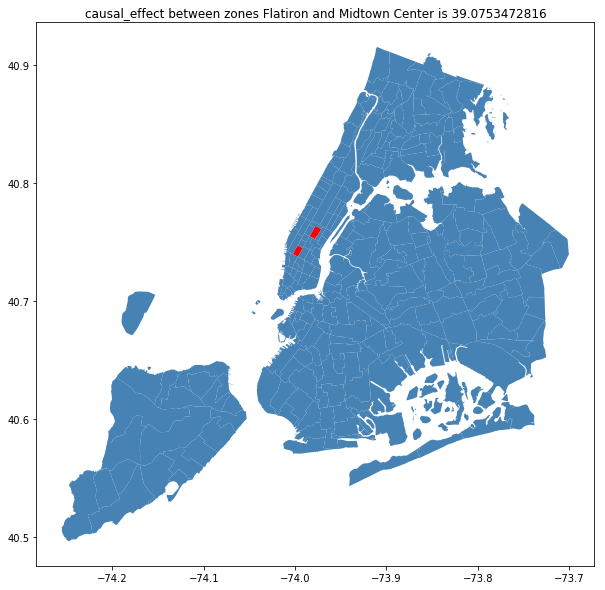

In [84]:
for i in [14]:
    ZoneDetection(clustered_zones_s[i])

- The clustering shows these two zones are highly homogeneous that we can use them to estimate the causal effect.

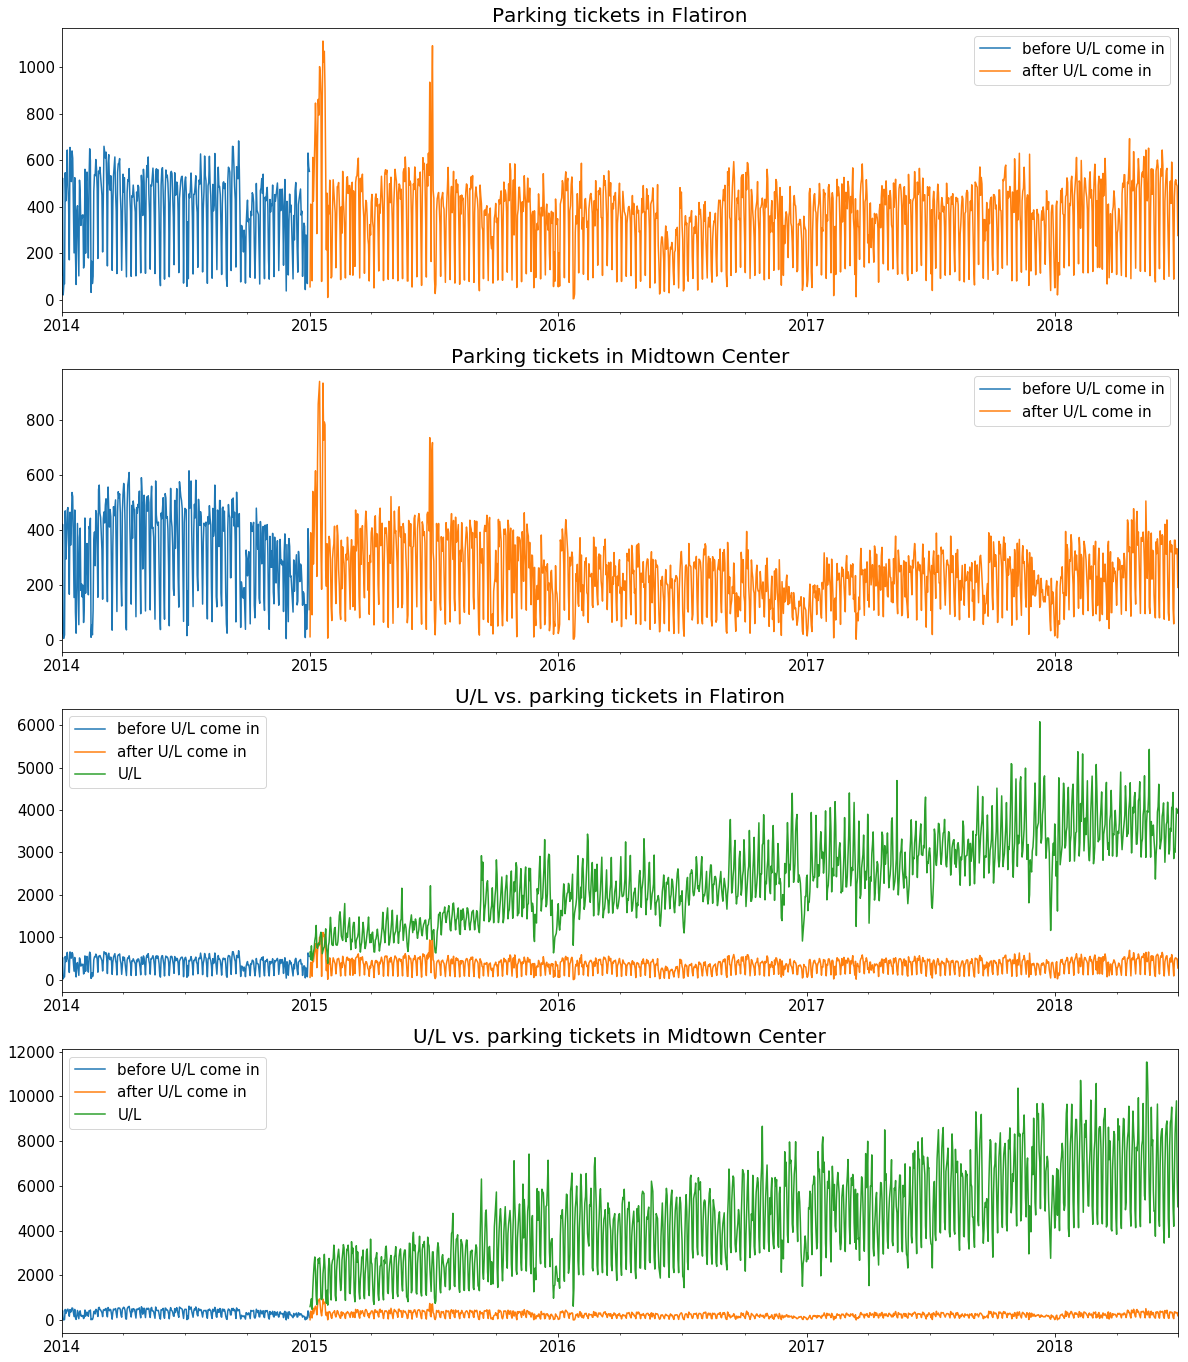

In [85]:
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)

clustered_zones = clustered_zones_s[14]
count = len(clustered_zones)
f = plt.figure(figsize=(20, count * 12))

for i, v in enumerate(clustered_zones):
    ax = f.add_subplot(count * 2, 1, i + 1)
    ticket2014[ticket2014.zone == v].sort_values("date").plot(x="date", y="count", ax=ax, label="before U/L come in")
    df[df.zone == v].sort_values("date").plot(x="date", y="tickets", ax=ax, label="after U/L come in")
    ax.set_title("Parking tickets in %s"%taxi_zones[taxi_zones.OBJECTID == v].zone.tolist()[0], fontsize=20)
    ax.set_xlabel('')
    ax.tick_params(axis='both', which='major', labelsize=15)

for i, v in enumerate(clustered_zones):
    ax = f.add_subplot(count * 2, 1, i + count + 1)
    ticket2014[ticket2014.zone == v].sort_values("date").plot(x="date", y="count", ax=ax, label="before U/L come in")
    df[df.zone == v].sort_values("date").plot(x="date", y="tickets", ax=ax, label="after U/L come in")
    df[df.zone == v].sort_values("date").plot(x="date", y="pickup", ax=ax, label="U/L")
    ax.set_title("U/L vs. parking tickets in %s"%taxi_zones[taxi_zones.OBJECTID == v].zone.tolist()[0], fontsize=20)
    ax.set_xlabel('')
    ax.tick_params(axis='both', which='major', labelsize=15)

- The average number of parking violation are almost same in 2014 in both zones, while are clearly different in 2015-2018. The clustering proves that they are highly homogenous in many aspects. With parallel assumption, we can infer that the huge gap between the average number of Uber/Lyft trips is responsible for such a differentiation of violation in the two zones.

In [86]:
def AvgCausalEffect(clustered_zones, timestamp):
    vs = []
    tickets14s = []
    trips = []
    tickets15s = []
    for i, v in enumerate(clustered_zones):
        tickets14 = ticket2014[ticket2014.zone == v]["count"].mean()
        tickets15 = df[df.date < timestamp][df.zone == v]["tickets"].mean()
        trip = df[df.date < timestamp][df.zone == v]["pickup"].mean()
        vs.append(v)
        tickets14s.append(tickets14)
        trips.append(trip)
        tickets15s.append(tickets15)
        
    causal_effects = []
    for i in range(len(vs)):
        for j in range(i + 1, len(vs)):
            causal_effect = (trips[i] - trips[j]) / ((tickets15s[j] - tickets14s[j]) - 
                                                     (tickets15s[i] - tickets14s[i]))
            causal_effects.append(causal_effect)
            
    return causal_effects

In [87]:
CE18 = []
for clustered_zones in clustered_zones_s:
    CE18 += AvgCausalEffect(clustered_zones, "2019-01-01")
np.average(CE18)

224.23747945269344

- The average effects of all homogeneous pairs is 224.2, which implies that an increase of 224.2 Uber & Lyft pickups in New York is associated with a decrease of 1 parking ticket.